# Denoising Auto Encoder Implementation in TensorFlow 

# Remove the Guassian Noise 

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch: 1 - cost= 0.21037
Epoch: 1 - cost= 0.20408
Epoch: 1 - cost= 0.21502
Epoch: 1 - cost= 0.19098
Epoch: 1 - cost= 0.18185
Epoch: 1 - cost= 0.19519
Epoch: 1 - cost= 0.19629
Epoch: 1 - cost= 0.19690
Epoch: 1 - cost= 0.18144
Epoch: 1 - cost= 0.17870
Epoch: 1 - cost= 0.18364
Epoch: 1 - cost= 0.17456
Epoch: 1 - cost= 0.17836
Epoch: 1 - cost= 0.17644
Epoch: 1 - cost= 0.17816
Epoch: 1 - cost= 0.17119
Epoch: 1 - cost= 0.17413
Epoch: 1 - cost= 0.16603
Epoch: 1 - cost= 0.17288
Epoch: 1 - cost= 0.16467
Epoch: 1 - cost= 0.16056
Epoch: 1 - cost= 0.16299
Epoch: 1 - cost= 0.16419
Epoch: 1 - cost= 0.15930
Epoch: 1 - cost= 0.16324
Epoch: 1 - cost= 0.15614
Epoch: 1 - cost= 0.15742
Epoch: 1 - cost= 0.15882
Epoch: 1 - cost= 0.16121
Epoch: 1 - cost= 0.16360
Epoch: 1 - cost= 0.15918
Epoch: 1 - cost= 0.15881
Epoch:

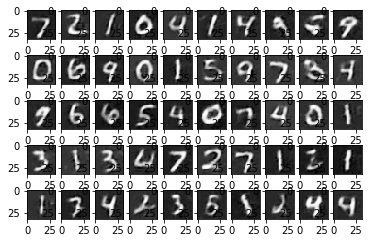

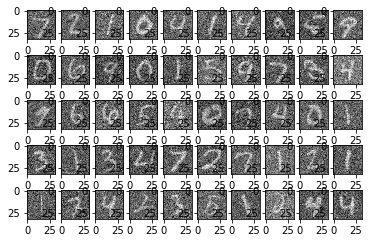

In [5]:
# Import the required library

import tensorflow.contrib.layers as lays
import numpy as np
from skimage import transform
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt 

def autoencoder(inputs):
    # encoder
    # 32 x 32 x 1   ->  16 x 16 x 32
    # 16 x 16 x 32  ->  8 x 8 x 16
    # 8 x 8 x 16    ->  2 x 2 x 8
    net = lays.conv2d(inputs, 32, [5, 5], stride=2, padding='SAME')
    net = lays.conv2d(net, 16, [5, 5], stride=2, padding='SAME')
    net = lays.conv2d(net, 8, [5, 5], stride=4, padding='SAME')
    # decoder
    # 2 x 2 x 8    ->  8 x 8 x 16
    # 8 x 8 x 16   ->  16 x 16 x 32
    # 16 x 16 x 32  ->  32 x 32 x 1
    net = lays.conv2d_transpose(net, 16, [5, 5], stride=4, padding='SAME')
    net = lays.conv2d_transpose(net, 32, [5, 5], stride=2, padding='SAME')
    net = lays.conv2d_transpose(net, 1, [5, 5], stride=2, padding='SAME', activation_fn=tf.nn.tanh)
    return net

def resize_batch(imgs):
    # A function to resize a batch of MNIST images to (32, 32)
    # Args:
    #   imgs: a numpy array of size [batch_size, 28 X 28].
    # Returns:
    #   a numpy array of size [batch_size, 32, 32].
    imgs = imgs.reshape((-1, 28, 28, 1))
    resized_imgs = np.zeros((imgs.shape[0], 32, 32, 1))
    for i in range(imgs.shape[0]):
        resized_imgs[i, ..., 0] = transform.resize(imgs[i, ..., 0], (32, 32))
    return resized_imgs

# Introduce Gaussian Noise
def noisy(image):
    row,col= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = image + gauss
    return noisy
    

# Introduce Salt and Pepper Noise
def s_p(image):
    row,col = image.shape
    s_vs_p = 0.5
    amount = 0.05
    out = np.copy(image)
      # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    out[coords] = 1

      # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    out[coords] = 0
    return out

ae_inputs = tf.placeholder(tf.float32, (None, 32, 32, 1))  # input to the network (MNIST images)
ae_inputs_noise = tf.placeholder(tf.float32, (None, 32, 32, 1)) 
ae_outputs = autoencoder(ae_inputs_noise)  # create the Autoencoder network

# calculate the loss and optimize the network
loss = tf.reduce_mean(tf.square(ae_outputs - ae_inputs))  # claculate the mean square error loss
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

# initialize the network
init = tf.global_variables_initializer()

batch_size = 500  # Number of samples in each batch
epoch_num = 5     # Number of epochs to train the network
lr = 0.001        # Learning rate

# read MNIST dataset
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

# calculate the number of batches per epoch
batch_per_ep = mnist.train.num_examples // batch_size

with tf.Session() as sess:
    sess.run(init)
    for ep in range(epoch_num):  # epochs loop
        for batch_n in range(batch_per_ep):  # batches loop
            batch_img, batch_label = mnist.train.next_batch(batch_size)  # read a batch
            batch_img = batch_img.reshape((-1, 28, 28, 1))               # reshape each sample to an (28, 28) image
            batch_img = resize_batch(batch_img)                          # reshape the images to (32, 32)
            image_arr = []
#            for i in xrange(len(batch_img)):
            for i in range(len(batch_img)):

                img = batch_img[i,:,:,0]
                img = noisy(img)
                image_arr.append(img)
            image_arr = np.array(image_arr)
            image_arr = image_arr.reshape(-1,32,32,1)
            batch_img = image_arr
            _, c = sess.run([train_op, loss], feed_dict={ae_inputs: batch_img,ae_inputs_noise:image_arr})
            print('Epoch: {} - cost= {:.5f}'.format((ep + 1), c))

    # test the trained network
    batch_img, batch_label = mnist.test.next_batch(50)
    batch_img = resize_batch(batch_img)
    image_arr = []
    
#    for i in xrange(50):
    for i in range(50):
        img = batch_img[i,:,:,0]
        img = noisy(img)
        image_arr.append(img)
    image_arr = np.array(image_arr)
    image_arr = image_arr.reshape(-1,32,32,1)
    batch_img = image_arr
            
    recon_img = sess.run([ae_outputs], feed_dict={ae_inputs_noise: batch_img})[0]

    # plot the reconstructed images and their ground truths (inputs)
    plt.figure(1)
    plt.title('Reconstructed Images')
    for i in range(50):
        plt.subplot(5, 10, i+1)
        plt.imshow(recon_img[i, ..., 0], cmap='gray')
    plt.figure(2)
    plt.title('Input Images with Gaussian Noise')
    for i in range(50):
        plt.subplot(5, 10, i+1)
        plt.imshow(batch_img[i, ..., 0], cmap='gray')
    plt.show()

# Remove the Salt and Pepper Noise

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch: 1 - cost= 0.10759
Epoch: 1 - cost= 0.10432
Epoch: 1 - cost= 0.09145
Epoch: 1 - cost= 0.10456
Epoch: 1 - cost= 0.09399
Epoch: 1 - cost= 0.10294
Epoch: 1 - cost= 0.09214
Epoch: 1 - cost= 0.09225
Epoch: 1 - cost= 0.08686
Epoch: 1 - cost= 0.08006
Epoch: 1 - cost= 0.06995
Epoch: 1 - cost= 0.07494
Epoch: 1 - cost= 0.07498
Epoch: 1 - cost= 0.07392
Epoch: 1 - cost= 0.07664
Epoch: 1 - cost= 0.07144
Epoch: 1 - cost= 0.06985
Epoch: 1 - cost= 0.07153
Epoch: 1 - cost= 0.06950
Epoch: 1 - cost= 0.06736
Epoch: 1 - cost= 0.06618
Epoch: 1 - cost= 0.06272
Epoch: 1 - cost= 0.06388
Epoch: 1 - cost= 0.06702
Epoch: 1 - cost= 0.06042
Epoch: 1 - cost= 0.05949
Epoch: 1 - cost= 0.05825
Epoch: 1 - cost= 0.06138
Epoch: 1 - cost= 0.05908
Epoch: 1 - cost= 0.05936
Epoch: 1 - cost= 0.05768
Epoch: 1 - cost= 0.06140
Epoch:

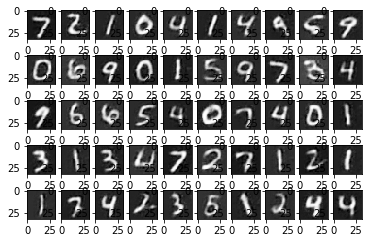

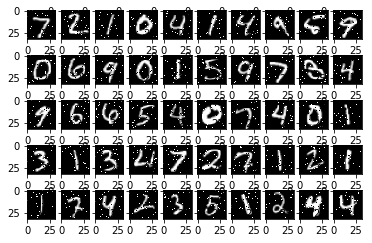

In [6]:
batch_size = 1000  # Number of samples in each batch
epoch_num = 10     # Number of epochs to train the network
lr = 0.001        # Learning rate

# read MNIST dataset
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

# calculate the number of batches per epoch
batch_per_ep = mnist.train.num_examples // batch_size

with tf.Session() as sess:
    sess.run(init)
    for ep in range(epoch_num):  # epochs loop
        for batch_n in range(batch_per_ep):  # batches loop
            batch_img, batch_label = mnist.train.next_batch(batch_size)  # read a batch
            batch_img = batch_img.reshape((-1, 28, 28, 1))               # reshape each sample to an (28, 28) image
            batch_img = resize_batch(batch_img)                          # reshape the images to (32, 32)
            image_arr = []
            for i in range(len(batch_img)):
                img = batch_img[i,:,:,0]
                img = s_p(img)
                image_arr.append(img)
            image_arr = np.array(image_arr)
            image_arr = image_arr.reshape(-1,32,32,1)
            #batch_img = image_arr
            _, c = sess.run([train_op, loss], feed_dict={ae_inputs_noise:image_arr,ae_inputs: batch_img})
            print('Epoch: {} - cost= {:.5f}'.format((ep + 1), c))

    # test the trained network
    batch_img, batch_label = mnist.test.next_batch(50)
    batch_img = resize_batch(batch_img)
    image_arr = []
    
    for i in range(50):
        img = batch_img[i,:,:,0]
        img = s_p(img)
        image_arr.append(img)
    image_arr = np.array(image_arr)
    image_arr = image_arr.reshape(-1,32,32,1)
    #batch_img = image_arr
            
    recon_img = sess.run([ae_outputs], feed_dict={ae_inputs_noise: image_arr})[0]

    # plot the reconstructed images and their ground truths (inputs)
    plt.figure(1)
    plt.title('Reconstructed Images')
    for i in range(50):
        plt.subplot(5, 10, i+1)
        plt.imshow(recon_img[i, ..., 0], cmap='gray')
    plt.figure(2)
    plt.title('Input Noisy Images with Salt and Pepper Noise')
    for i in range(50):
        plt.subplot(5, 10, i+1)
        plt.imshow(image_arr[i, ..., 0], cmap='gray')
    plt.show()